# Regresja i klasyfikacja

Implementacja drzew decyzyjnych tworzonych algorytmem ID3 z ograniczeniem maksymalnej głębokości drzewa oraz stworzenia i zbadania jakości klasyfikatorów dla zbioru danych `breast cancer` (https://archive.ics.uci.edu/ml/datasets/breast+cancer). 

Klasą jest poleirradiat, a użyte dane podzielono na zbiory trenujący, walidacyjny i testowy. 


## Używane biblioteki

In [26]:
import pandas as pd
import numpy as np
from typing import List, Iterable, Any, Dict, Union, Callable
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from multiprocessing import Pool
import seaborn as sns
from functools import partial
import warnings
warnings.filterwarnings('ignore')

In [4]:
def load_data(filename):
    '''
    function that loads data and returns a dataframe
    '''
    df = pd.read_csv(filename, header=None)
    df.columns = [
        "Class",
        "age",
        "menopause",
        "tumor-size",
        "inv-nodes",
        "node-caps",
        "deg-malig",
        "breast",
        "breast-quad",
        "irradiat",
    ]
    return df

## Walidacja krzyżowa

Walidacja krzyżowa jest procedurą ponownego próbkowania używaną do oceny modeli uczenia maszynowego na ograniczonej próbce danych.

Ogólna procedura jest następująca:

1. Potasuj losowo zbiór danych.
2. Podziel zbiór danych na k grup.

Dla każdej unikalnej grupy:

3. Weź daną grupę jako wstrzymany lub walidacyjny zbiór danych
4. Weź pozostałe grupy jako zestaw danych treningowych
5. Dopasuj model na zbiorze treningowym i oceń go na zbiorze walidacyjnym.
6. Zachowaj wynik oceny i odrzuć model
7. Podsumuj umiejętności modelu używając określonej metryki na zbiorze walidacyjnym


In [5]:
def cross_validation_split(df, split_count, stratification_target="irradiat", seed=0):
    """
    Cross validation function
    Returns a list of tuples (training dataframe, validation/test dataframe)
    """
    random_state = np.random.RandomState(seed)

    train_dfs: List[List[pd.DataFrame]] = []  # train_dfs[stratification_target_index][split_number]
    val_dfs = []
    for _, df_group in df.groupby(stratification_target):
        indices = np.arange(len(df_group))
        random_state.shuffle(indices)

        train_dfs.append([])
        val_dfs.append([])
        for split_number in range(split_count):
            # len(indices) / split_count -- approximated elements in one chunk
            val_start = round(split_number * len(indices) / split_count)
            val_end = round((split_number + 1) * len(indices) / split_count)
            val_indices = indices[val_start:val_end]
            train_indices = np.concatenate((indices[:val_start], indices[val_end:]))

            train_dfs[-1].append(df_group.iloc[train_indices])
            val_dfs[-1].append(df_group.iloc[val_indices])

    return [
        (pd.concat([dfs[i] for dfs in train_dfs]), pd.concat([dfs[i] for dfs in val_dfs])) for i in range(split_count)
    ]

In [155]:
def data_split(df, val_fraction, stratification_target='irradiat', seed=0):
    """
    Returns a tuple (training dataframe, validation/test dataframe)
    """
    random_state = np.random.RandomState(seed)

    train_dfs = []
    val_dfs = []
    for _, df_group in df.groupby(stratification_target):
        indices = np.arange(len(df_group))
        random_state.shuffle(indices)
        val_indices = indices[:round(val_fraction * len(indices))]
        train_indices = indices[round(val_fraction * len(indices)):]

        train_dfs.append(df_group.iloc[train_indices])
        val_dfs.append(df_group.iloc[val_indices])

    return pd.concat(train_dfs), pd.concat(val_dfs)

## Algorytm ID3

In [82]:
class Node:
    def __init__(self, feature, children):
        self.feature: str = feature
        self.children: Dict[str, Union[Node, Leaf]] = children
        
    def __repr__(self):
        return f'Node({repr(self.feature)}, {repr(self.children)})'


class Leaf:
    def __init__(self, value):
        self.value = value
        
    def __repr__(self):
        return f'Leaf({repr(self.value)})'


class ID3:
    def __init__(self, max_depth, threads=None):
        self._max_depth = max_depth
        self._threads = threads
        self._root = None
        self._most_frequent_class = None
        
    def __repr__(self):
        return f'ID3(root={self._root})'

    def _information_gain(self, X: pd.DataFrame, Y: pd.Series, x: str) -> float:
        '''
        Calculates information gain for a column `x` and returns it
        '''
        entropy = lambda Y: -sum([counts / len(Y) * np.log(counts / len(Y)) for counts in np.unique(Y, return_counts=True)[1]])
        divided_entropy = sum([(X[x] == j).sum() / len(X) * entropy(Y[X[x] == j]) for j in X[x].unique()])
        information_gain = entropy(Y) - divided_entropy
        return information_gain

    def _max_information_gain(self, X: pd.DataFrame, Y: pd.Series) -> str:
        '''
        Calculates for each features information gain and returns a feature column with the largest information gain
        '''
        features_entropy = [self._information_gain(X, Y, col) for col in X.columns]
        return X.columns[features_entropy.index(max(features_entropy))]

    def _fit_algorithm(self, X: pd.DataFrame, Y: pd.Series, depth: int) -> Union[Node, Leaf]:
        '''
        Main ID3 algorithm function, returns a Node or a Leaf
        '''
        if len(X) == 0 or len(X.columns) == 0:
            return Leaf(self._most_frequent_class)
        if depth == self._max_depth or Y.nunique() == 1:
            return Leaf(Counter(Y).most_common(1)[0][0])

        best_column = self._max_information_gain(X, Y)
        children = {}
        for value in X[best_column].unique():
            mask = X[best_column] == value
            children[value] = self._fit_algorithm(X[mask].drop(columns=best_column), Y[mask], depth + 1)
        return Node(best_column, children)

    def fit(self, X: pd.DataFrame, Y: pd.Series) -> None:
        '''
        fit function, that calculates a root node and most frequent class
        '''
        self._most_frequent_class = Counter(Y).most_common(1)[0][0]
        self._root = self._fit_algorithm(X, Y, 0)

    def _predict_single(self, sample: Dict[str, Any]) -> str:
        '''
        Predict a label for a single sample
        '''
        current_node: Union[Node, Leaf] = self._root
        while not isinstance(current_node, Leaf):
            value = sample[current_node.feature]
            current_node = current_node.children.get(value, None)
            if current_node is None:
                return self._most_frequent_class

        return current_node.value

    def predict(self, X: pd.DataFrame) -> Iterable[Any]:
        '''
        Returns predicted value of terminal Node on X
        '''
        if self._threads is not None:
            with Pool(self._threads) as pool:
                return pool.map(self._predict_single, [row for _, row in X.iterrows()])
        return list(map(self._predict_single, (row for _, row in X.iterrows())))

## Dodatkowy model Sklearn

In [8]:
import re

class SklearnModel:
    def __init__(self, model_class, **kwargs):
        self.model = model_class(**kwargs)
        self.name2index = {}  # {column_name -> {str_value -> index}}
        self.name2index_y = {}  # {str_value -> index}
        self.index2name_y = {}  # {index -> str_value}
        self._most_frequent_class = None
        
    @staticmethod
    def _sort_key(a):
        '''
        returns a key for sorting column values (to assign numerical values to columns as required by sklearn).
        It checks if value is in form 'number-number' and if that's the case it sorts it numerically.
        Sklearn decision tree uses comparison is nodes therefore the order is important.
        '''
        if isinstance(a, (int, float, np.int64)):
            return a
        m = re.match(r'^(\d+)-(\d+)$', a)
        if m is not None:
            return (int(m.group(1)), int(m.group(2)))
        return a

    def fit(self, X: pd.DataFrame, Y: pd.Series):
        self._most_frequent_class = Counter(Y).most_common(1)[0][0]
        
        # find a mapping between string feature value and numeric values (as required by sklearn)
        for column in X.columns:
            self.name2index[column] = {}
            for index, name in enumerate(sorted(X[column].unique(), key=self._sort_key)):
                self.name2index[column][name] = index
        for index, name in enumerate(sorted(Y.unique(), key=self._sort_key)):
            self.name2index_y[name] = index
            self.index2name_y[index] = name
            
        # substitute values using a found mapping
        X = X.copy()
        for column in X.columns:
            X[column] = X[column].apply(lambda value: self.name2index[column][value])
        Y = Y.apply(lambda value: self.name2index_y[value])

        self.model.fit(X, Y)

    def predict(self, X: pd.DataFrame) -> Iterable[Any]:
        # substitute values using a mappiing
        X = X.copy()
        for column in X.columns:
            X[column] = X[column].apply(lambda value: self.name2index[column].get(value))
            
        # find samples that contains unknown feature value during fitting and assigned them the most common class
        mask = X.isna().apply(lambda row: row.any(), axis=1).values

        res = np.array([self._most_frequent_class] * len(X), dtype=object)
        if not mask.all():
            res[~mask] = [self.index2name_y[y] for y in self.model.predict(X[~mask])]
        return res

## Funkcje rysujące oraz obliczające metryki

In [ ]:
def show_report(data: Dict[str, np.ndarray], name=""):
    """
    data[split_name] -> (ground_truth, predictions)
    where ground_truth and predictions have shape either (num_reps x num_samples) or (num_samples)
    Plots confusion matrix and bar plot(contains metrics and values of them) 
    """
    # map ground truths and predictions to 2d np.array if they are 1d.
    data = {k: tuple(map(lambda v: (v if len(v.shape) == 2 else v.reshape(1, -1)), vs)) for k, vs in data.items()}
    
    plt.figure(figsize=(20, 5 * len(data)))
    plt.suptitle(name)
    
    for i, (split, (ground_truth, preds)) in enumerate(data.items()):
        ax = plt.subplot(len(data), 2, 1 + 2 * i)
        plt.title(split)
        ConfusionMatrixDisplay.from_predictions(ground_truth.reshape(-1), preds.reshape(-1), normalize="all", ax=ax)

    plt.subplot(1, 2, 2)
    metrics = [
        (accuracy_score, "accuracy"),
        (lambda *args: precision_score(*args, pos_label="yes"), "precision"),
        (lambda *args: recall_score(*args, pos_label="yes"), "recall"),
        (lambda *args: f1_score(*args, pos_label="yes"), "f1"),
    ]

    df = pd.DataFrame.from_dict(
        {
            "value": [
                metric(gt[i], preds[i])
                for metric, _ in metrics
                for split, (gt, preds) in data.items()
                for i, _ in enumerate(gt)
            ],
            "split": [split for _, _ in metrics for split, (gt, _) in data.items() for _ in gt],
            "metric": [metric_name for _, metric_name in metrics for _, (gt, _) in data.items() for _ in gt],
        }
    )
    sns.barplot(df, x="metric", y="value", hue="split", errorbar='sd')

    plt.show()

In [175]:
def train_and_predict(model_func, train_df, val_df):
    model = model_func()

    model.fit(train_df.drop(columns="irradiat"), train_df.irradiat)

    val_preds = model.predict(val_df.drop(columns="irradiat"))
    val_gt = val_df.irradiat.values

    train_preds = model.predict(train_df.drop(columns="irradiat"))
    train_gt = train_df.irradiat.values

    return model, val_preds, val_gt, train_preds, train_gt

    
def plot_model(model_func: Callable[[], Any], df: pd.DataFrame, split_count, reps, name="", pool=None, return_hits=False):
    '''
    Trains models on multiple repetitions on CV and shows a report
    Returns mean of validatation and train data for every repetition
    '''
    if pool is None:
        pool =  Pool(1)
    
    val_predictions = []  # rep -> a list of CV predictions (by each single model) 3-dimensial
    val_ground_truth = []
    train_predictions = []
    train_ground_truth = []
    models = []
    
    async_results = []
    for rep in range(reps):
        async_results.append([])
        for train_df, val_df in cross_validation_split(df, split_count, seed=rep):
            async_results[-1].append(pool.apply_async(train_and_predict, (model_func, train_df, val_df)))
    
    for rep in range(reps):
        val_predictions.append([])
        val_ground_truth.append([])
        train_predictions.append([])
        train_ground_truth.append([])
        for split_index in range(split_count):
            model, val_preds, val_gt, train_preds, train_gt = async_results[rep][split_index].get()

            val_predictions[-1].append(val_preds)
            val_ground_truth[-1].append(val_gt)

            train_predictions[-1].append(train_preds)
            train_ground_truth[-1].append(train_gt)

            models.append(model)

    val_predictions = np.stack([np.concatenate(x) for x in val_predictions])
    val_ground_truth = np.stack([np.concatenate(x) for x in val_ground_truth])
    train_predictions = np.stack([np.concatenate(x) for x in train_predictions])
    train_ground_truth = np.stack([np.concatenate(x) for x in train_ground_truth])

    show_report({'training': (train_ground_truth, train_predictions), 'validation': (val_ground_truth, val_predictions)}, name=name)
    
    if return_hits:
        return val_ground_truth == val_predictions, train_ground_truth == train_predictions, models
    return (val_ground_truth == val_predictions).mean(1), (train_ground_truth == train_predictions).mean(1), models

In [164]:
def main(depths:Iterable=[*range(11), np.inf], split_count=10, reps=512, test_fraction=0.2, pool=None):
    '''
    Splits test and nontest data(data used for cross validation) and plots graph according to depth and 
    accuracy for each subdata(validation, train), finally shows current report for test subset in two ways.
    Contains plots and reports based on metrics.
    '''
    df = load_data("breast-cancer.data")
    nontest_df, test_df = data_split(df, test_fraction)
    print(f'training/validation samples: {len(nontest_df)} ({len(nontest_df) / len(df) * 100:.1f}%)')
    print(f'test samples: {len(test_df)} ({len(test_df) / len(df) * 100:.1f}%)')
    
    
    accuracies = {}  # dictionary of depth -> cross validation accuracy
    train_accuracies = {}
    models = {}
    for depth in depths:
        acc, train_acc, ms = plot_model(partial(ID3, max_depth=depth), nontest_df, name=f'ID3(depth={depth})', split_count=split_count, reps=reps, pool=pool)
        accuracies[depth] = acc
        train_accuracies[depth] = train_acc
        models[depth] = ms
        
        unique_models = sorted(set(map(repr, ms)))
        print(f'calculated {len(unique_models)} unique models')
        
    plt.title('cross-validation accuracy depending on a max tree depth')
    plt.xlabel('depth')
    plt.ylabel('accuracy')
    sns.lineplot(pd.DataFrame.from_dict({
        'depth': [depth for depth, accs in accuracies.items() for acc in accs.reshape(-1)],
        'accuracy': [acc for depth, accs in accuracies.items() for acc in accs.reshape(-1)],
        }), x='depth', y='accuracy', errorbar='sd')
    sns.lineplot(pd.DataFrame.from_dict({
        'depth': [depth for depth, accs in train_accuracies.items() for acc in accs.reshape(-1)],
        'accuracy': [acc for depth, accs in train_accuracies.items() for acc in accs.reshape(-1)],
        }), x='depth', y='accuracy', errorbar='sd')
    plt.legend(['validation', 'training', 'validation std', 'training std'])
    plt.show()
        
    best_depth = max(accuracies.items(), key=lambda x: x[1].mean())[0]
    print(f'Best depth on validation: {best_depth} with accuracy {accuracies[best_depth].mean() * 100:.1f}%')

    print(f'test accuracy for all models with depth {best_depth}: ', end='')
    test_predictions = []
    for model in models[best_depth]:
        test_prediction = model.predict(test_df.drop(columns='irradiat'))
        test_predictions.append(test_prediction)
        test_accuracy = (test_prediction == test_df.irradiat).mean()
        print(f'{test_accuracy * 100:.2f}%', end=' ')
    print()
    test_predictions = np.stack(test_predictions, axis=1)
    
    ensemble_prediction = np.array(list(map(lambda models_preds: Counter(models_preds).most_common(1)[0][0], test_predictions)))
    print(f'ensemble test accuracy: {(ensemble_prediction == test_df.irradiat).mean() * 100:.2f}%')
    show_report({'test': (test_df.irradiat.values, ensemble_prediction)}, name=f'Ensemble of {len(models[best_depth])} ID3(depth={best_depth}) models')
    
    model = ID3(best_depth)
    model.fit(nontest_df.drop(columns='irradiat'), nontest_df.irradiat)
    predictions = np.array(list(model.predict(test_df.drop(columns='irradiat'))))
    print(f'single-model test accuracy: {(predictions == test_df.irradiat).mean() * 100:.2f}%')
    show_report({'test': (test_df.irradiat.values, predictions)}, name=f'Single ID3(depth={best_depth}) model')
    print(repr(model))

## Wykresy 

training/validation samples: 228 (79.7%)
test samples: 58 (20.3%)


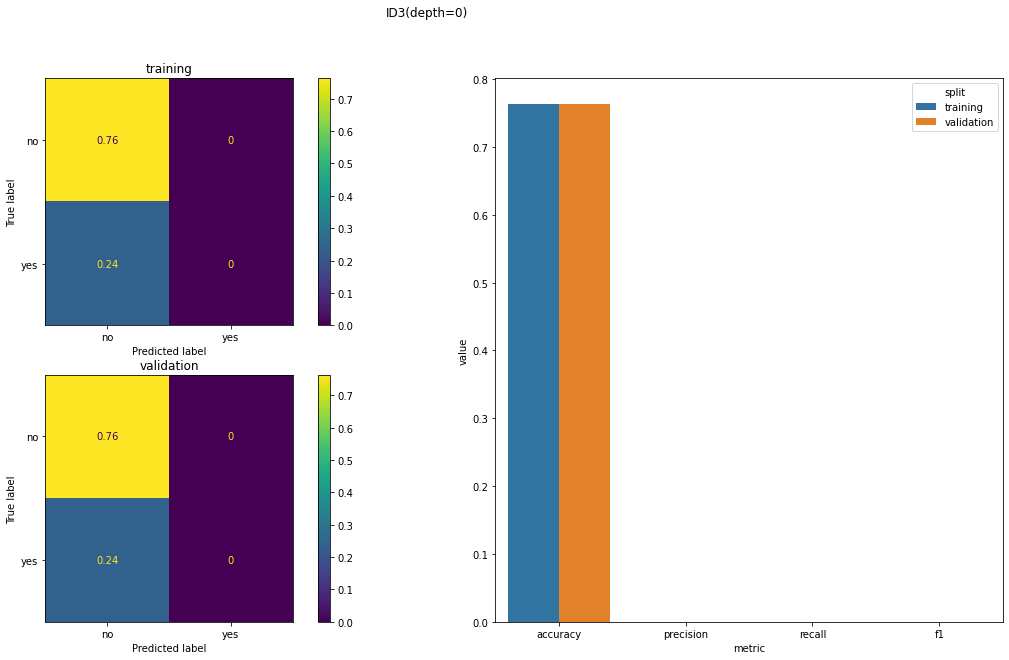

calculated 1 unique models


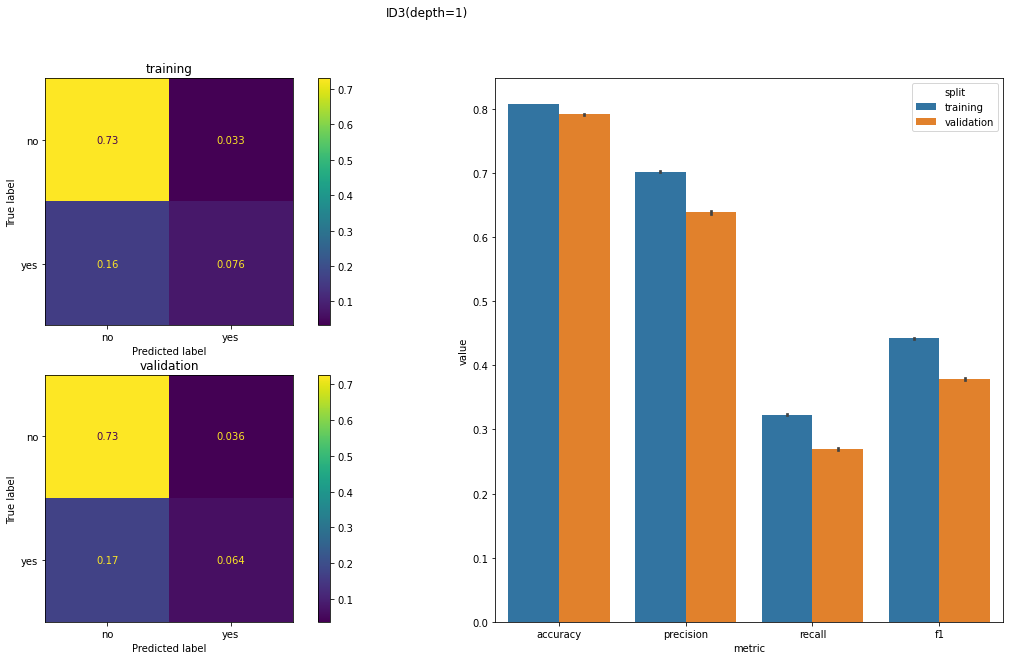

calculated 248 unique models


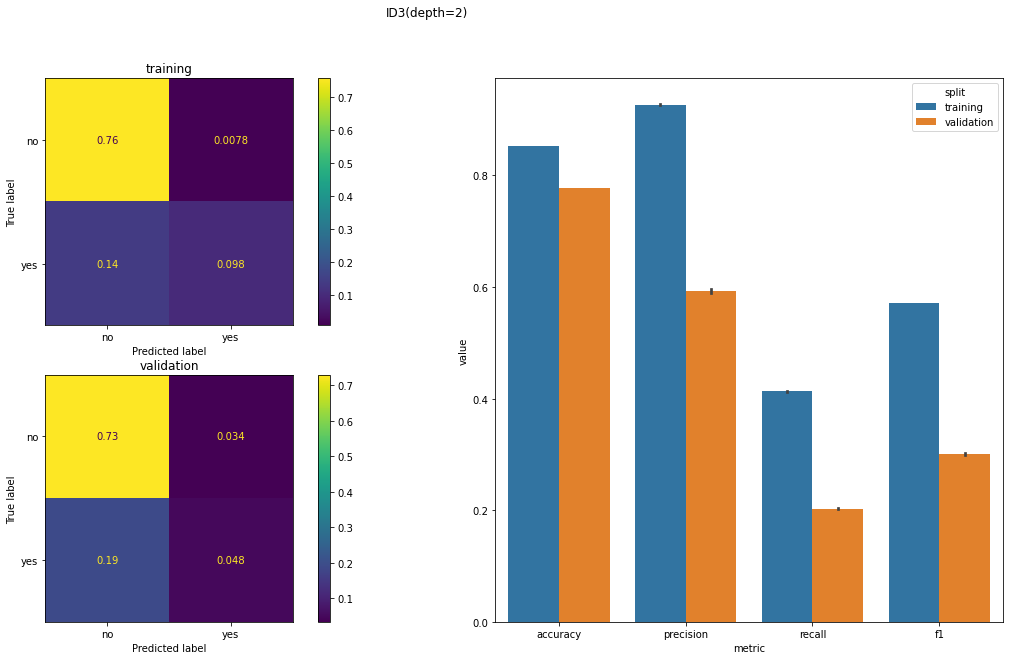

calculated 5000 unique models


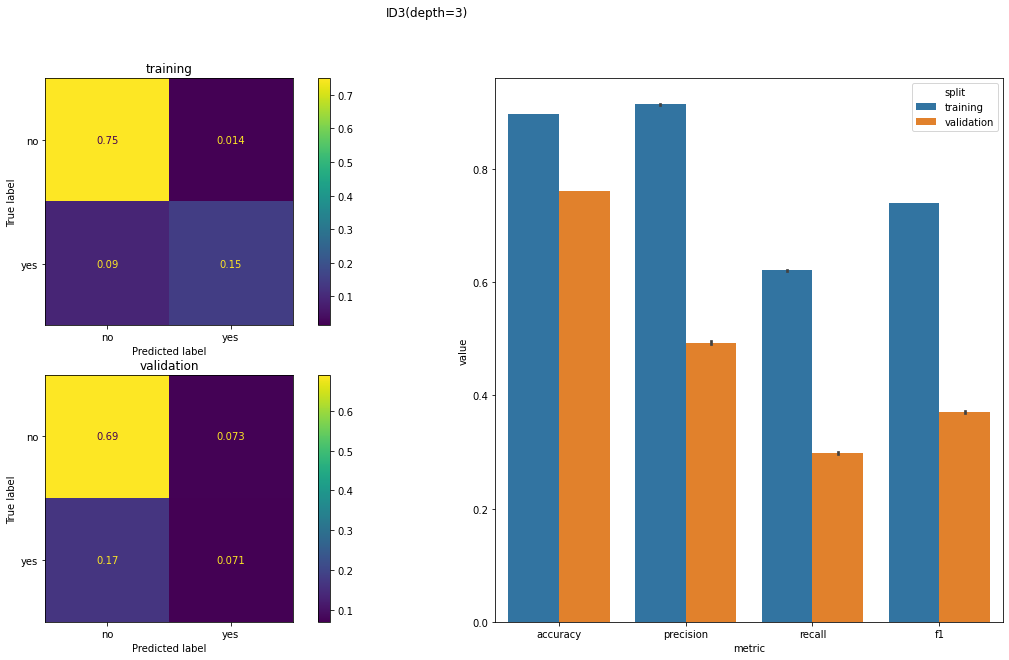

calculated 5120 unique models


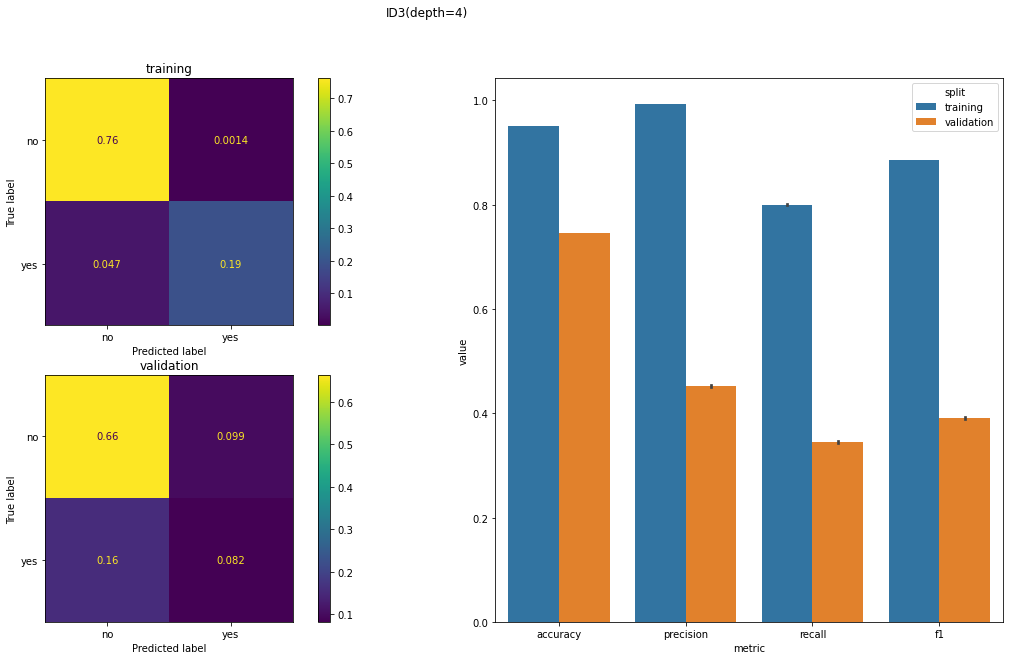

calculated 5120 unique models


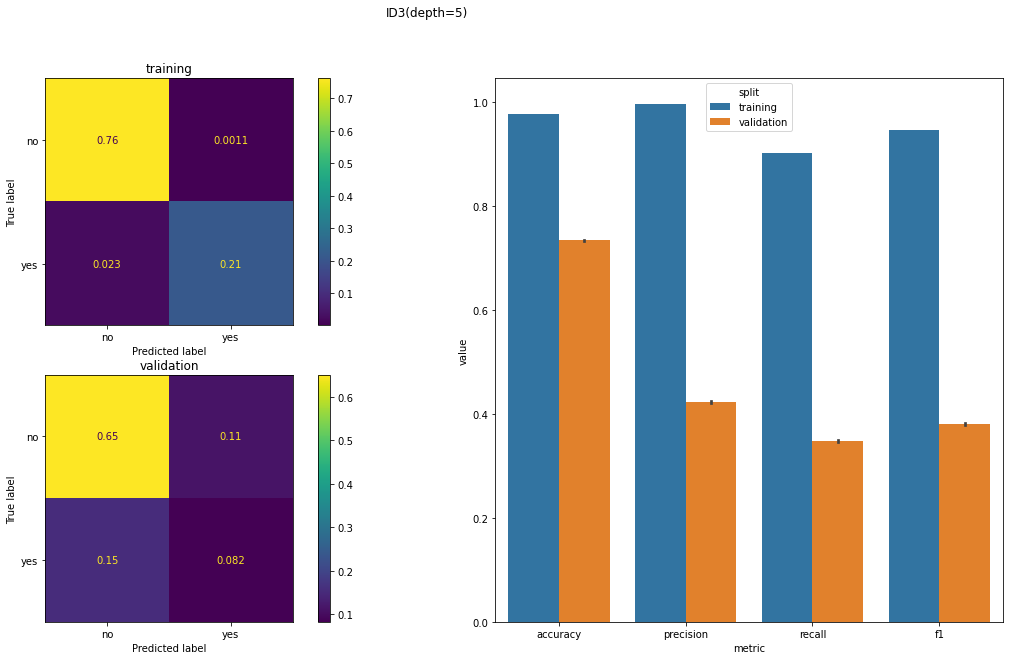

calculated 5120 unique models


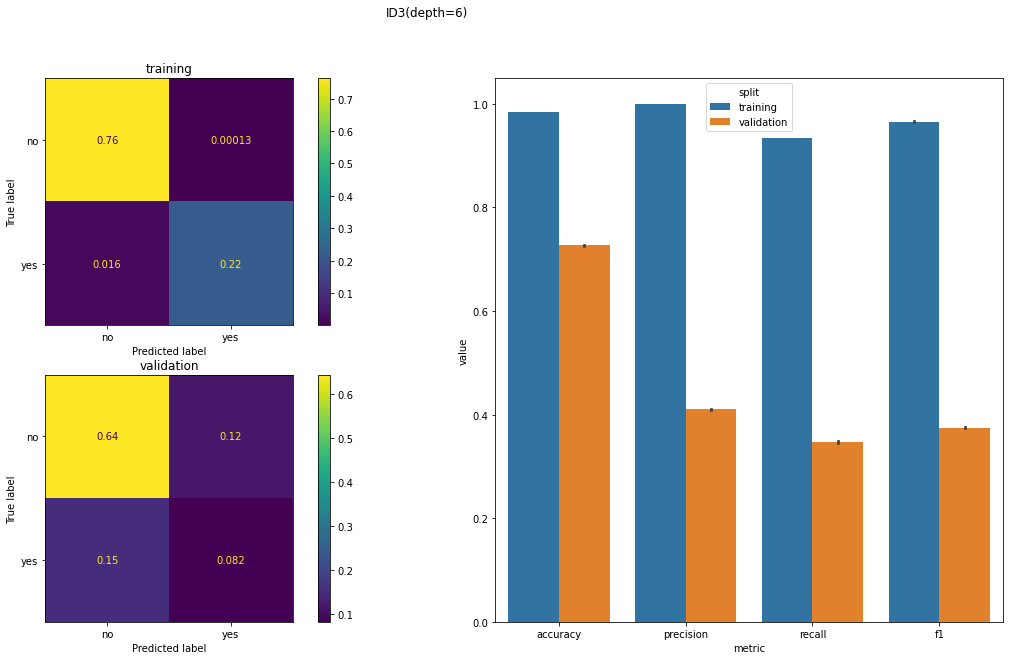

calculated 5120 unique models


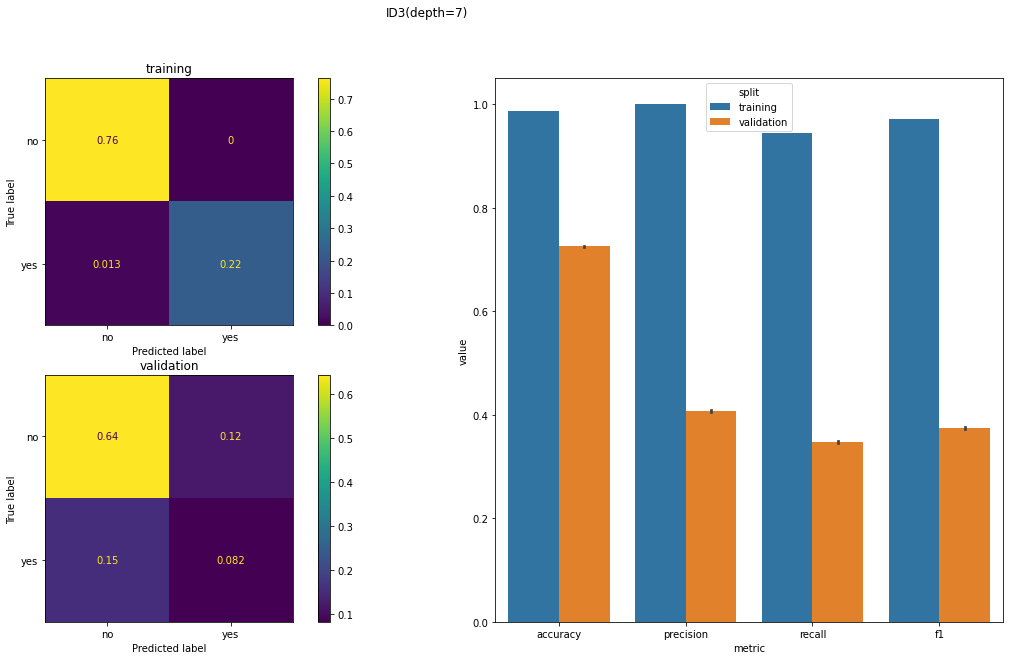

calculated 5120 unique models


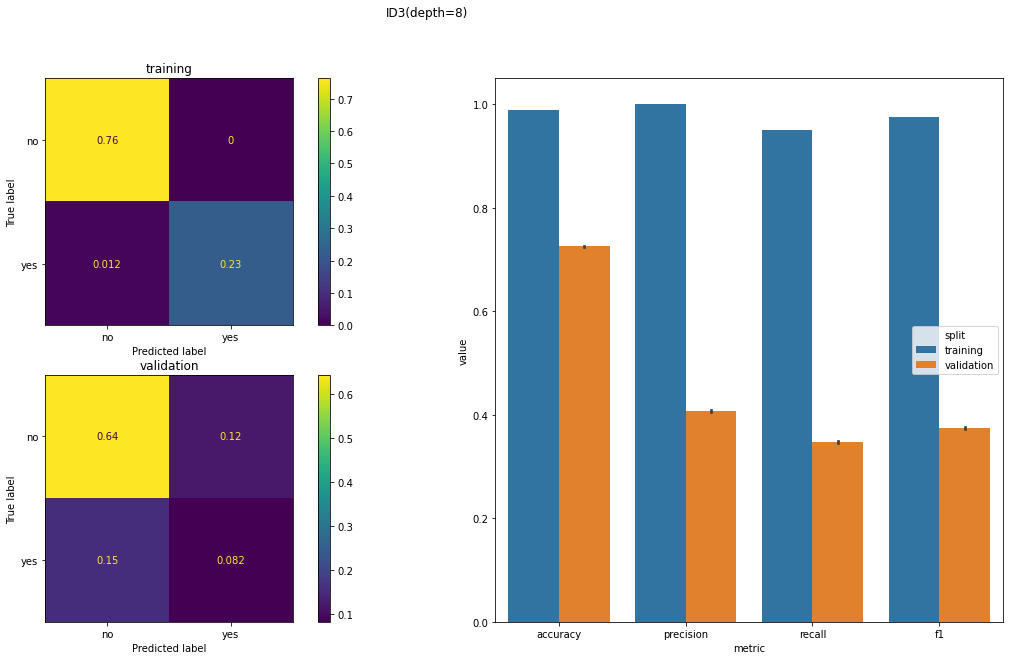

calculated 5120 unique models


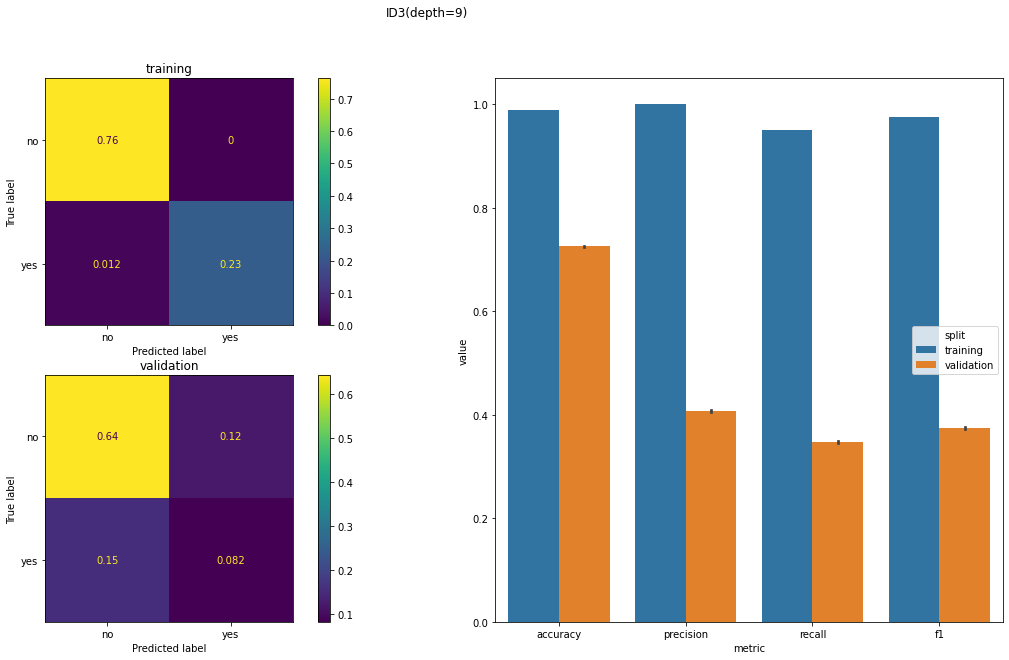

calculated 5120 unique models


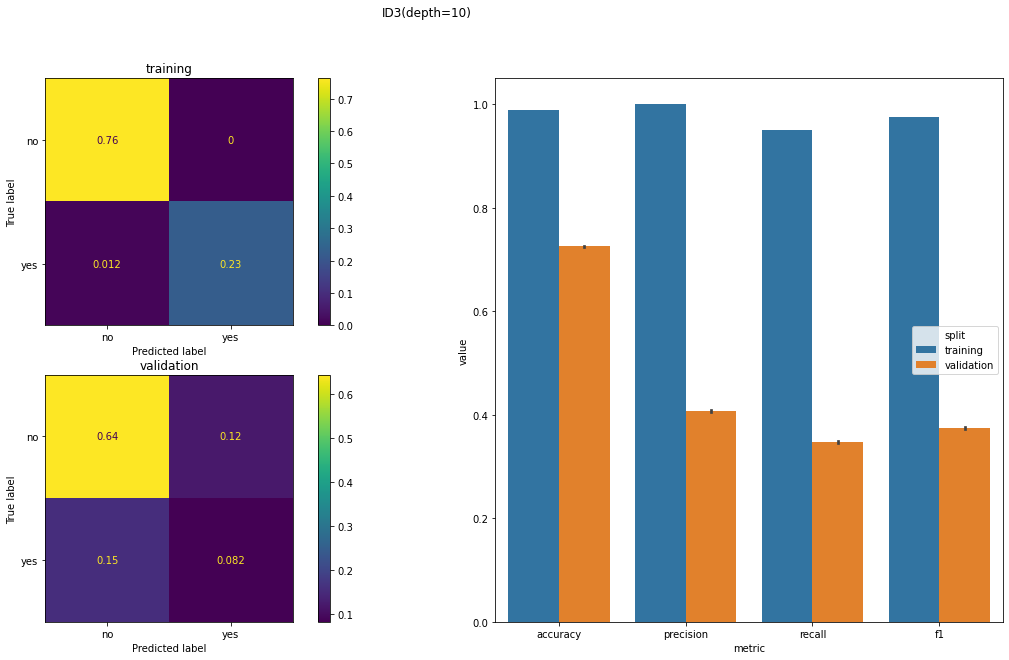

calculated 5120 unique models


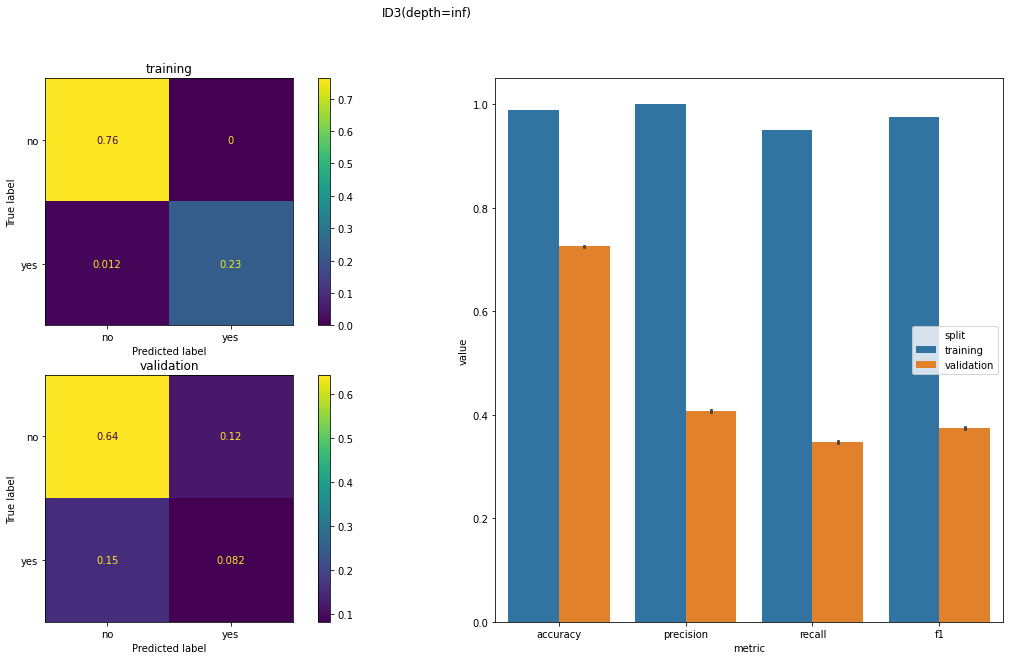

calculated 5120 unique models


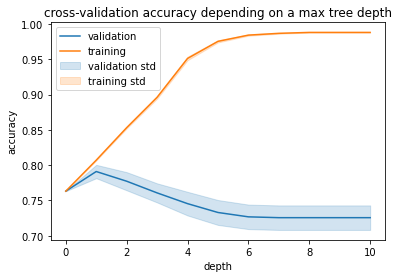

Best depth on validation: 1 with accuracy 79.1%
test accuracy for all models with depth 1: 74.14% 74.14% 74.14% 74.14% 75.86% 74.14% 75.86% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 75.86% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 75.86% 74.14% 74.14% 74.14% 75.86% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 75.86% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 75.86% 74.14% 74.14% 74.14% 74.14% 75.86% 74.14% 74.14% 74.14% 74.14% 75.86% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 75.86% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 75.86% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 75.86% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 74.14% 75.86% 74.14% 74.14% 74.14% 74.14% 74.14% 75.86% 74.14% 74.14% 74.14% 74.14% 75.86% 74.14% 74.14% 74.14% 74.14%

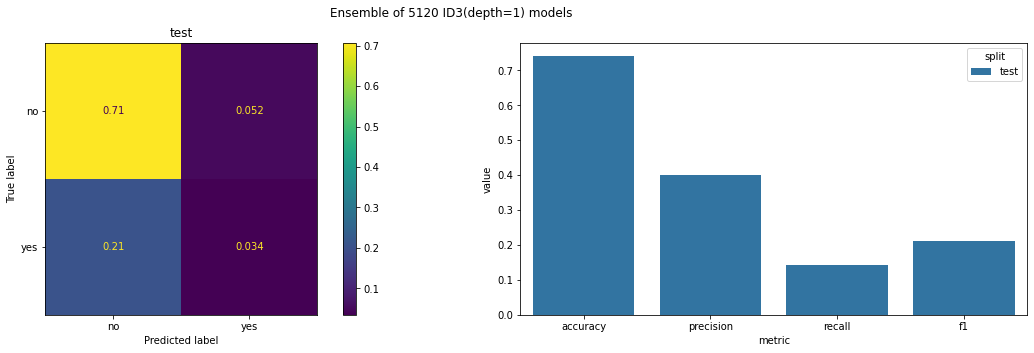

single-model test accuracy: 74.14%


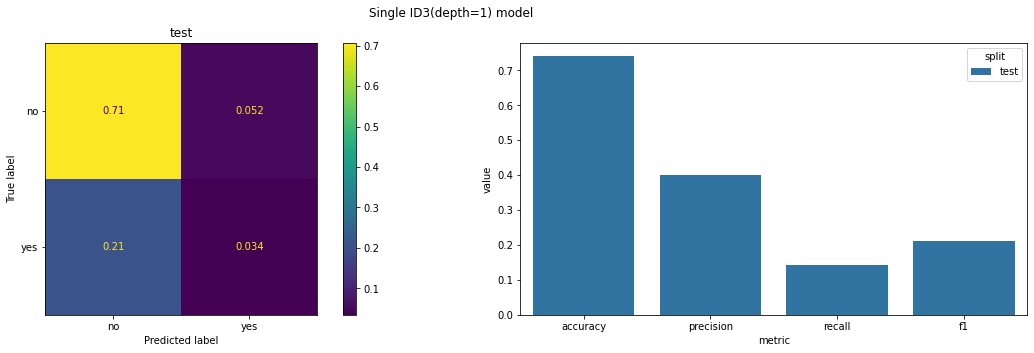

ID3(root=Node('inv-nodes', {'0-2': Leaf('no'), '3-5': Leaf('no'), '6-8': Leaf('yes'), '15-17': Leaf('no'), '9-11': Leaf('yes'), '12-14': Leaf('yes'), '24-26': Leaf('yes')}))


In [165]:
with Pool(24) as pool:
    main(pool=pool)

## Wnioski

Przy podziale datasetu na podzbiory trenujące/walidacyjne(samples: 228 (79.7%)) oraz testujący(test samples: 58 (20.3%)) otrzymano najlepszą 
głębokość 1 na zbiorze walidacyjnym o wartości accuracy **79.1%**. Przy głębokości drzewa równej 3, można zauważyć maksymalną liczbę unikalnych/różnych modeli, identycznie przy zwiększaniu głębokości. Dla subsetu zbioru testowego osiągnięto accuracy  **74.14%** w obu przypadkach.

Na wykresie(depth-accuracy) widać od wartości głębokości 2 zjawisko przeuczenia (rosnie accuracy na trainingowych danych i maleje na walidacyjnych).


Większe liczba K(w programie split_count) oznacza mniejszą tendencję do szacowania prawdziwego oczekiwanego błędu (ponieważ fałdy(folds) treningowe będą bliższe całkowitemu zbiorowi danych i testujemy większą liczbe różnych modeli), i wyższy czas pracy (ponieważ zbliżamy się do przypadku granicznego: Leave-One-Out CV).

Na wykresach słupkowych obserwowalne odchylenia standardowe wynikające z ilości repetycji dla walidacji krzyżowej.


Trywialny model, który odpowiada zawsze "no" osiąga accuracy 76% (procent class "no" w datasecie) (dla kazdego splitu, jako że robimy stratyfikacje po klasie).
Najlepszy model na zbiorze testowym osiąga wartość niższą (74.14%), co może oznaczać że:
* wybór losowych elementów dla zbioru testowego jest niefortunny (np. trudny lub inny niz w reszcie danych)
* wynik cross-walidacji (79.1%) jest zbiasowany wyborem najlepszego modelu.

Oznacza to że ten model może nie być lepsze od zwracania zawsze "no" (nie mamy wystarczająco danych żeby to zwalidować lepiej). Może to być spowodowane:
* za małą liczbą sampli w zbiorze treningowym (228)
* problem jest trudny do predykcji (tzn. atrybuty nie są wystarczająca informatywne) (widoczne w datasecie jest nawet że dla identycznych atrybutów dane są inne klasy)


## Porównanie algorytmu ID3 z modelami zaimportowanymi z biblioteki sklearn
W tej sekcji nie szukamy najleprzych hiperparametrow modeli, zatem nie dzielimy danych na zbiór testowych i na reszte (zamiast tego robimy tylko cross-walidacje)

In [42]:
df = load_data('breast-cancer.data')

In [47]:
df

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...
281,recurrence-events,30-39,premeno,30-34,0-2,no,2,left,left_up,no
282,recurrence-events,30-39,premeno,20-24,0-2,no,3,left,left_up,yes
283,recurrence-events,60-69,ge40,20-24,0-2,no,1,right,left_up,no
284,recurrence-events,40-49,ge40,30-34,3-5,no,3,left,left_low,no


In [ ]:
import os
import time
def pool_initializer():
    np.random.seed((os.getpid() * int(time.time())) % 123456789)

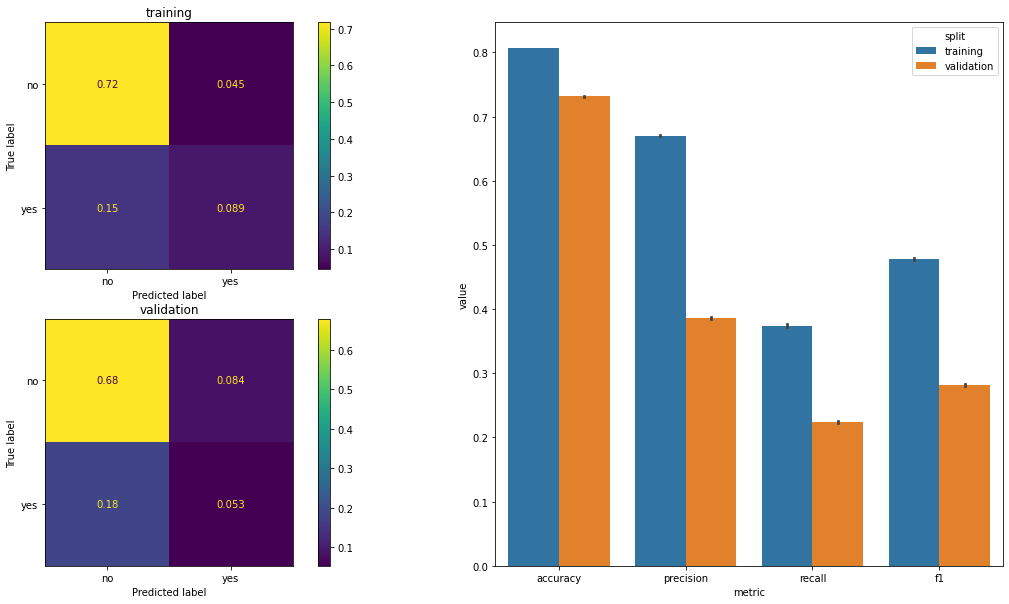

In [45]:
import sklearn.tree
with Pool(24, initializer=pool_initializer) as pool:
    plot_model(partial(SklearnModel, sklearn.tree.DecisionTreeClassifier, max_depth=3), df, reps=512, split_count=10, pool=pool)

Dla modelu drzewa decyzyjnego zaimportowanego z biblioteki sklearn accuracy wynosi 73% na tym samym zbiorze danych (najprawdopodobniej overfitting)

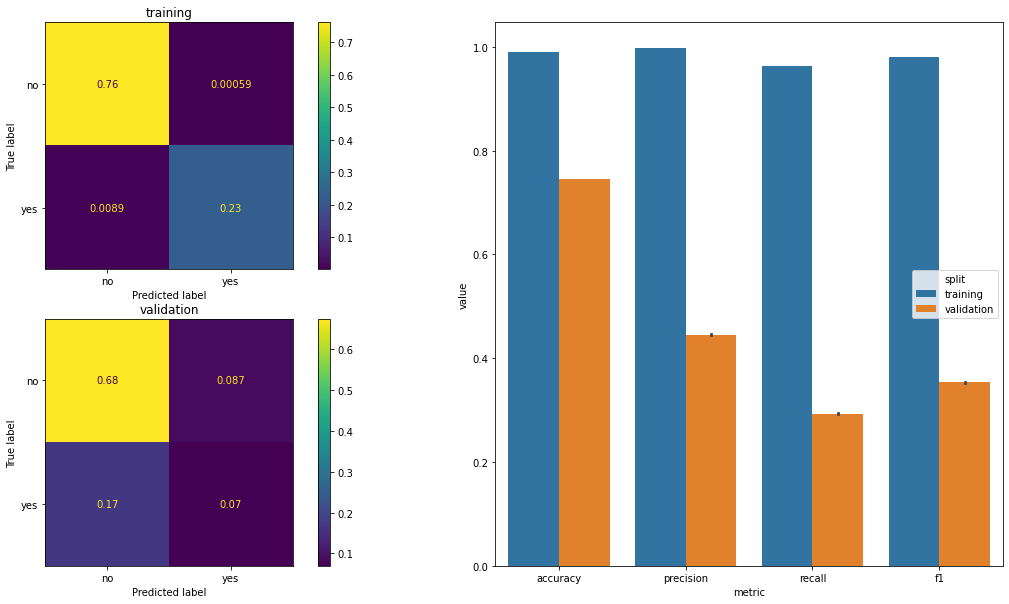

In [170]:
import sklearn.ensemble
with Pool(24, initializer=pool_initializer) as pool:
    plot_model(partial(SklearnModel, sklearn.ensemble.RandomForestClassifier, n_estimators=100), df, reps=512, split_count=10, pool=pool)

Dla modelu lasu losowego accuracy wynosi 75% na identycznym zbiorze danych.

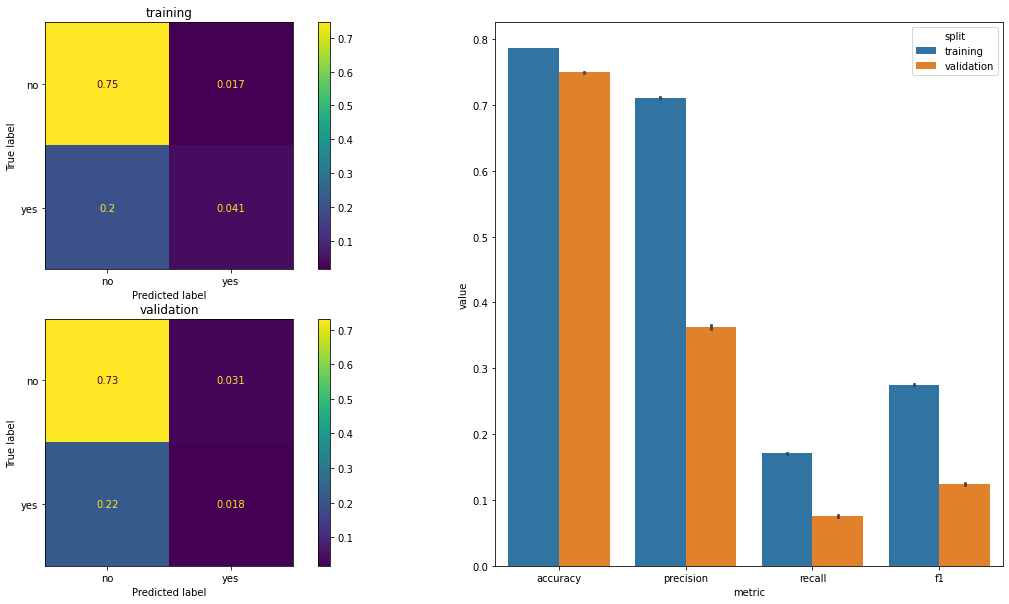

In [171]:
import sklearn.svm
with Pool(24, initializer=pool_initializer) as pool:
    plot_model(partial(SklearnModel, sklearn.svm.SVC), df, reps=512, split_count=10, pool=pool)

Dla modelu SVM accuracy wynosi 75% na identycznym zbiorze danych.

In [206]:
for _, d in df.groupby(list(df.keys().drop('irradiat'))):
    if d.irradiat.nunique() > 1:
        display(d)

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
38,no-recurrence-events,40-49,premeno,10-14,0-2,no,2,left,left_low,no
197,no-recurrence-events,40-49,premeno,10-14,0-2,no,2,left,left_low,yes


,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
25,no-recurrence-events,40-49,premeno,25-29,0-2,no,2,left,left_up,no
191,no-recurrence-events,40-49,premeno,25-29,0-2,no,2,left,left_up,yes


,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
29,no-recurrence-events,60-69,ge40,30-34,0-2,no,2,left,left_low,no
134,no-recurrence-events,60-69,ge40,30-34,0-2,no,2,left,left_low,yes


W podanym datasetcie występują identyczne wartości dla podanych atrybutów, ale zwracające inną wartość klasy(yes/no). Może to oznaczać że atrybuty nie są wystarczająco informatywne do predykcji klasy.

# Sprawdzenie statystycznej możliwości różnicy pomiędzy wynikiem na zbiorze testowym a walidacyjnym

In [172]:
nontest_df, test_df = data_split(df, val_fraction=0.2)  # podział taki sam jak w głównej sekcji

In [129]:
assert not set(nontest_df.index).intersection(test_df.index)

In [130]:
len(test_df), len(nontest_df)

(58, 228)

In [178]:
split_count = 10
max_depth = 1

Obliczamy ID3 z głębokością 1 (tzn najleprzą) z dużą liczbą repetycji (1024)

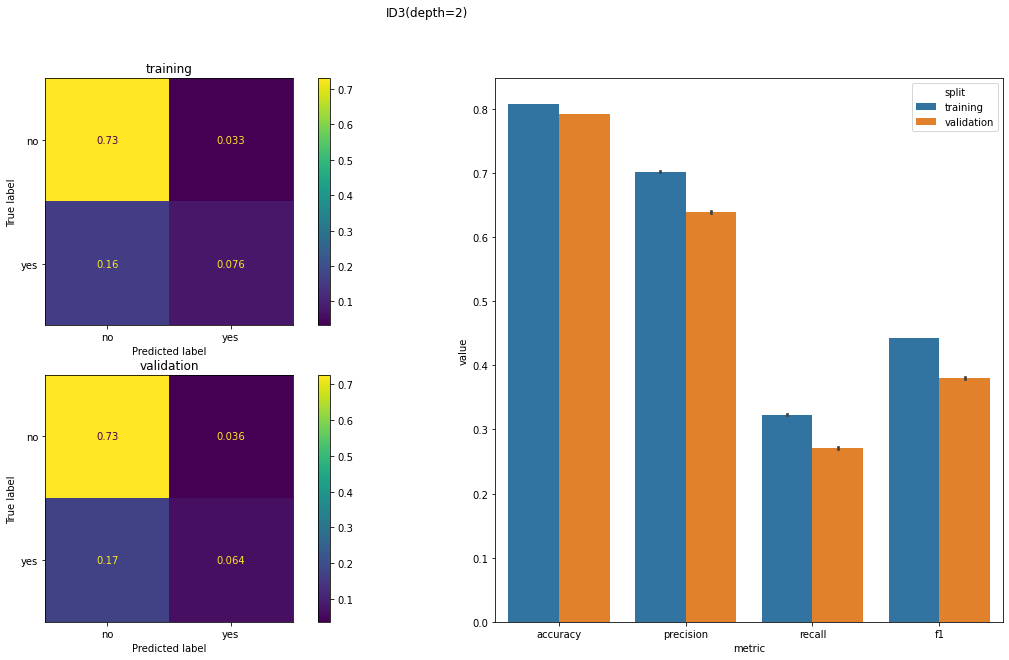

In [179]:
with Pool(24, initializer=pool_initializer) as pool:
    val_hits, train_hits, models = plot_model(partial(ID3, max_depth=max_depth), nontest_df, name=f'ID3(depth={2})', split_count=split_count, reps=1024, pool=pool, return_hits=True)

Sztucznie dzielimy predykcje z cross-validacji żeby uzyskać takie same liczebności próbek jak przy zbiorze testowych (tzn. 58 próbek na nowego "sztucznego" splita)

In [222]:
data = np.concatenate([rep_hit[:174].reshape(3, -1).mean(1) for rep_hit in val_hits])

wizualizacja statystyk ze sztucznych splitow 58 samplowych z cross-walidacji

mean=0.80322265625, std=0.04199913719932159, min=0.603448275862069, max=0.9137931034482759


<AxesSubplot:ylabel='Density'>

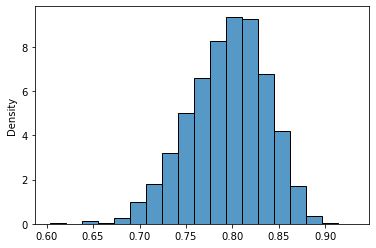

In [223]:
print(f'mean={data.mean()}, std={data.std()}, min={data.min()}, max={data.max()}')
sns.histplot(data, stat='density', binwidth=1 / 58)  # pdf

Jak widac, jest dość spory rozrzut pomiędzy wartościami validacji na splitach 58 elementowych.
Osiągnięcie wyniku testowego (tzn. 74.1 może nie być tak nieprawdopodobne). Obliczmy to:

In [208]:
model = ID3(max_depth=max_depth)
model.fit(nontest_df.drop(columns='irradiat'), nontest_df.irradiat)
test_acc = (model.predict(test_df.drop(columns='irradiat')) == test_df.irradiat).mean()
test_acc

0.7413793103448276

Text(0.5, 1.0, 'p-value of test split selection: 11.2%')

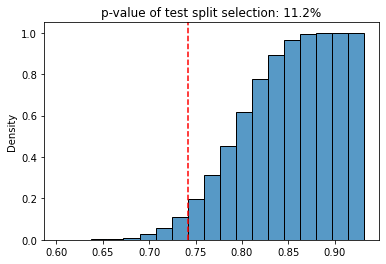

In [209]:
sns.histplot(data, stat='density', binwidth=1 / 58, cumulative=True)  # cdf
plt.axvline(test_acc, color='red', linestyle='--')
plt.title(f'p-value of test split selection: {np.mean(data <= test_acc) * 100:.1f}%')

Prawdopodobniestwo że losowy zbiór testowy ma accuracy tylko 74.1% wynosi 11.2%